In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_csv("spam.csv", encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
print("Number of rows: ",df.shape[0])
print("Number of columns: ",df.shape[1])

Number of rows:  5572
Number of columns:  5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
dup = df.duplicated().sum()
print(f'Total Duplicated rows are {dup}')

Total Duplicated rows are 403


In [9]:
df.isnull().sum()

,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


In [10]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [11]:
for i in df.columns.tolist():
  print("No. of unique values in",i,"is",df[i].nunique())

No. of unique values in v1 is 2
No. of unique values in v2 is 5169
No. of unique values in Unnamed: 2 is 43
No. of unique values in Unnamed: 3 is 10
No. of unique values in Unnamed: 4 is 5


In [12]:
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

In [13]:
df.drop(columns={'Unnamed: 2','Unnamed: 3','Unnamed: 4'}, inplace=True)

In [14]:
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [15]:
df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [16]:
X_train,X_test,y_train,y_test=train_test_split(df.Message,df.Spam,test_size=0.25)

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())

    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

In [19]:
clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])


Train ROC AUC: 0.9853827337271046
Test ROC AUC: 0.9588559013322232


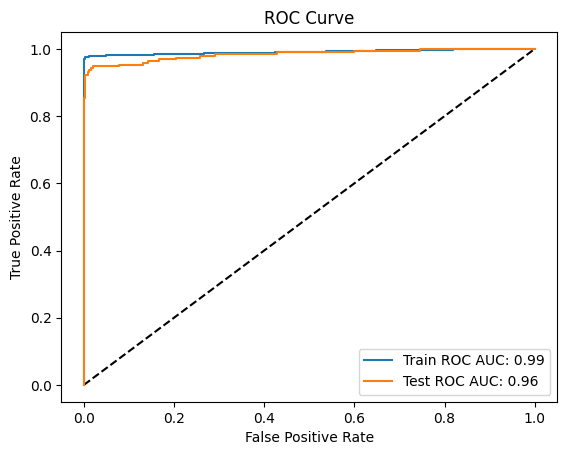


Confusion Matrix:


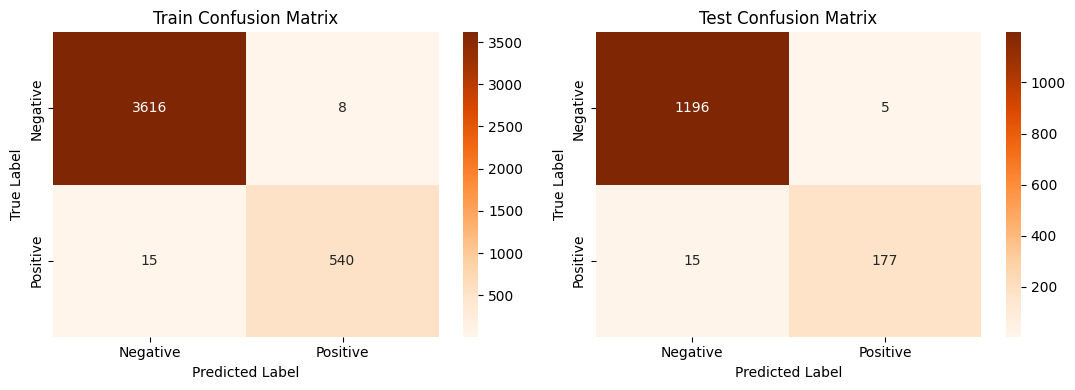


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.995869 | 0.997792 |   0.99683  | 3624        |
| 1            |    0.985401 | 0.972973 |   0.979148 |  555        |
| accuracy     |    0.994496 | 0.994496 |   0.994496 |    0.994496 |
| macro avg    |    0.990635 | 0.985383 |   0.987989 | 4179        |
| weighted avg |    0.994479 | 0.994496 |   0.994481 | 4179        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.987614 | 0.995837 |   0.991708 | 1201        |
| 1            |    0.972527 | 0.921875 |   0.946524 |  192        |
| accuracy     |    0.985642 | 0.985642 |   0.985642 |    0.985642 |
| macro avg    |    0.980071 | 0.958856 |   0.969116 | 1393        |
| weighted avg |    0.985534 | 0.985642 |   

In [20]:
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)

In [21]:
def detect_spam(email_text):
    prediction = clf.predict([email_text])

    if prediction == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"

In [22]:
sample_email = 'Free Tickets for IPL'
result = detect_spam(sample_email)
print(result)

This is a Spam Email!
